# Univariate Time Series Anomaly Detection

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# get data

path = './machine_temperature_system_failure.csv'
df = pd.read_csv(path)

# 1. Data Preprosessing

In [3]:
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [4]:
df.tail()

,timestamp,value
22690,2014-02-19 15:05:00,98.185415
22691,2014-02-19 15:10:00,97.804168
22692,2014-02-19 15:15:00,97.135468
22693,2014-02-19 15:20:00,98.056852
22694,2014-02-19 15:25:00,96.903861


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


We have a time series consisting of 22695 non-null data points collected every 5 minutes, from 2013-12-02 21:15:00 to 2014-02-19 15:25:00.

In [6]:
#convert datetime format and set as index

df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df = df.set_index("timestamp")

We expect 288 data points for each day, since data points were collected every 5 minutes. Let's check whether there exist 288 data point for each day.

In [7]:
df['MM-DD'] = df.index.strftime('%m-%d')
dpoints_daily = df.groupby(df['MM-DD']).size()

In [8]:
dpoints_daily.unique()

array([288, 300, 186,  33])

In [9]:
#locate the relevant dates for the data point counts other than 288

(dpoints_daily[dpoints_daily == 300], 
 dpoints_daily[dpoints_daily == 186], 
 dpoints_daily[dpoints_daily == 33])

(MM-DD
 01-07    300
 dtype: int64,
 MM-DD
 02-19    186
 dtype: int64,
 MM-DD
 12-02    33
 dtype: int64)

*12-02* and *02-19* are starting and ending days as we can see above, so we may expect lesser data points for these days. But we need to check for *01-07*.

In [10]:
dpoints_0107 = df[df['MM-DD'] == '01-07'].index.strftime('%H:%M:%S')
dpoints_0107[dpoints_0107.duplicated()]

Index(['02:00:00', '02:05:00', '02:10:00', '02:15:00', '02:20:00', '02:25:00',
       '02:30:00', '02:35:00', '02:40:00', '02:45:00', '02:50:00', '02:55:00'],
      dtype='object', name='timestamp')

In [11]:
# duplicated timestamps

df.loc['2014-01-07 02:00:00':'2014-01-07 02:55:00'].drop('MM-DD', axis=1)

,value
timestamp,
2014-01-07 02:00:00,94.423406
2014-01-07 02:05:00,94.698730
2014-01-07 02:10:00,95.332824
2014-01-07 02:15:00,95.079199
2014-01-07 02:20:00,94.881208
2014-01-07 02:25:00,94.563961
2014-01-07 02:30:00,93.430922
2014-01-07 02:35:00,93.729663
2014-01-07 02:40:00,93.192987


Since observation values are different for duplicated timestamps, we may assign average values.

In [12]:
df = df.groupby(axis='index', level=0).mean()

In [13]:
# add anomaly labels taken from Numenta data sets

df_anomaly_points = df.loc[["2013-12-11 06:00:00", "2013-12-16 17:25:00", "2014-01-28 13:55:00",
                            "2014-02-08 14:30:00"]]
df['is_anomaly'] = False
df.loc[df.index.isin(df_anomaly_points.index), ['is_anomaly']] = True

In [14]:
df.query('is_anomaly')

,value,is_anomaly
timestamp,,
2013-12-11 06:00:00,102.736214,True
2013-12-16 17:25:00,2.084721,True
2014-01-28 13:55:00,51.367154,True
2014-02-08 14:30:00,25.887752,True


# 2. Statistical descriptive analysis

In [15]:
df['value'].describe()

count    22683.000000
mean        85.922259
std         13.749300
min          2.084721
25%         83.074740
50%         89.403332
75%         94.014429
max        108.510543
Name: value, dtype: float64

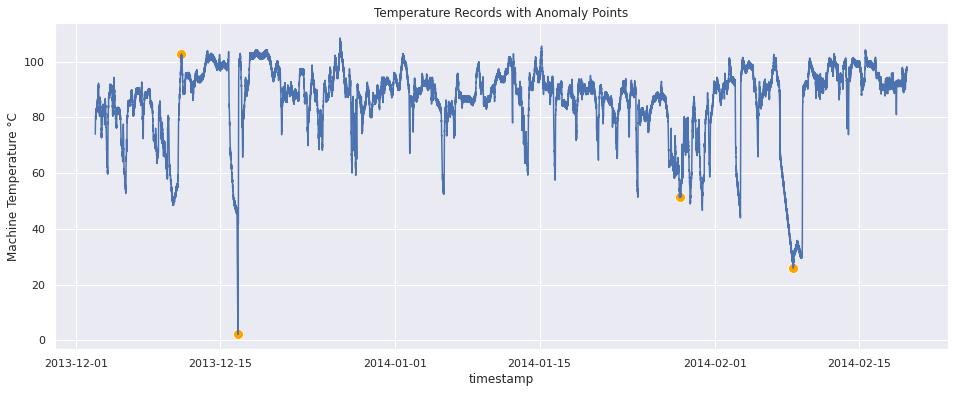

In [16]:
sns.set(rc={'figure.figsize':(16, 6)})

sns.lineplot(data=df, x='timestamp', y='value')
sns.scatterplot(data=df[df['is_anomaly']], x='timestamp', y='value', color='orange', s=100)
plt.title('Temperature Records with Anomaly Points')
plt.ylabel('Machine Temperature °C');

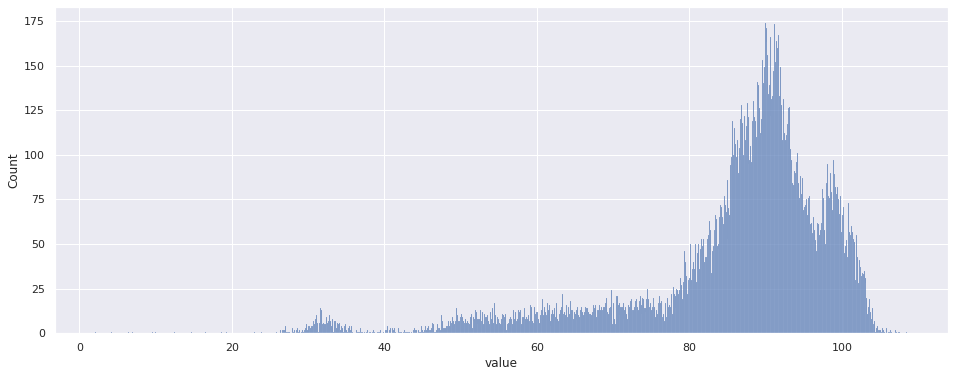

In [17]:
results_ = sns.histplot(data=df['value'], bins = 1000)

Based on visual check, there seems no obvious trend or seasionality, rather an unclear varying seasonality which may depend on both day time and week days due to characterics of the problem. Besides, the temperature values fluctuate around approx. 90°C. The histogram plot shows a left tail multimodal distribution. The graph below reveals that data does not exhibit a normal distribution.

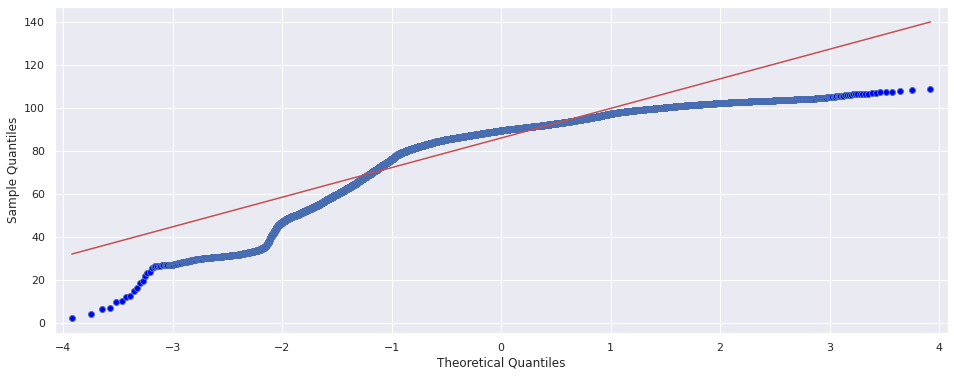

In [18]:
from statsmodels.graphics.gofplots import qqplot

results_ = qqplot(df['value'], line='s')

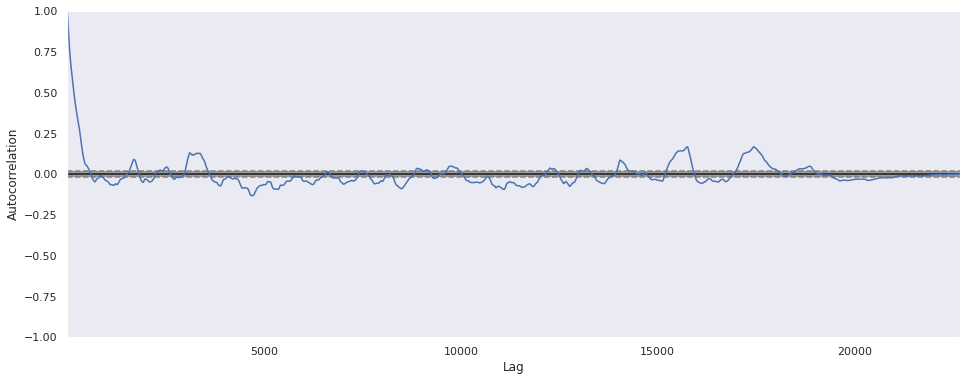

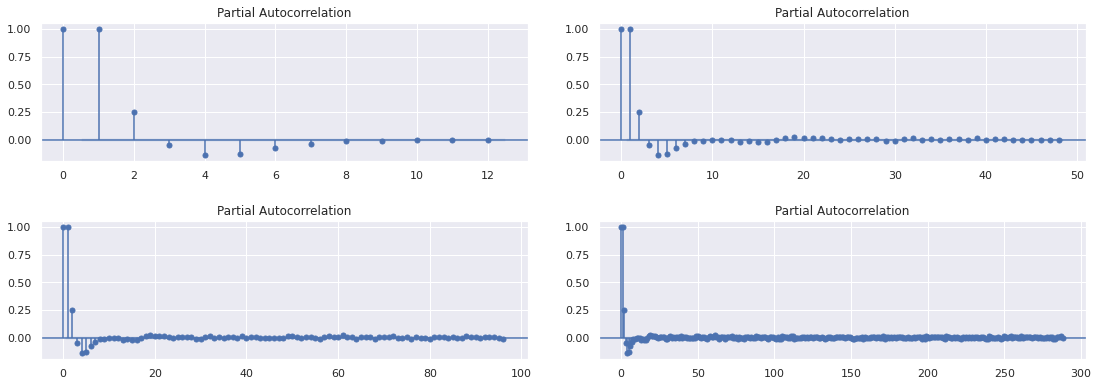

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

results_ = autocorrelation_plot(df['value'])
f, ax = plt.subplots(2, 2)
lags = [12, 48, 96, 288] # (for 1, 4, 8 hours and 1 day respectively)
ax = ax.ravel()
f.tight_layout(pad=3.0)

for i in range(len(lags)):
        results_ = plot_pacf(df['value'], lags=lags[i], ax=ax[i])

Auto correlation graphs provides info regarding correlation among elements at certain time points. If there exists any seasonality (eg. hourly, daily, weekly) we can observe a spike at that point. These graphs doesn't provide any obvious correlation at above mentioned time frames (Only *lag 1* (+5 min) shows high correlation).

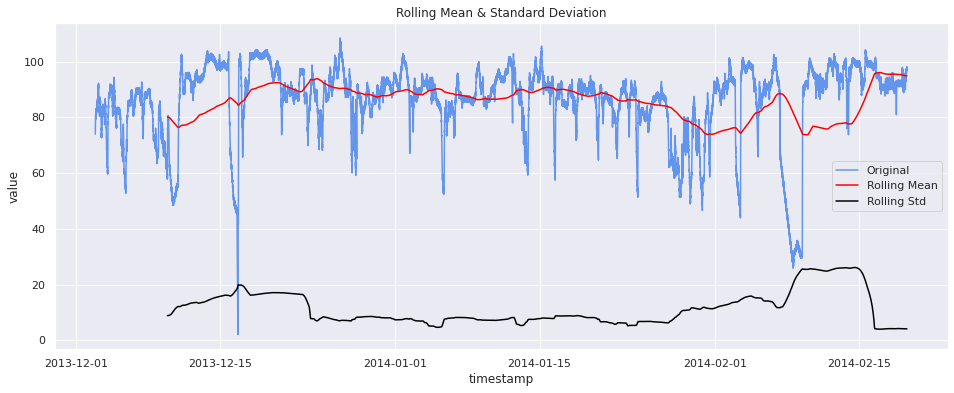

Results of Dickey-Fuller Test:
Test Statistic                -7.367464e+00
p-value                        9.156132e-11
#Lags Used                     2.000000e+01
Number of Observations Used    2.266200e+04
Critical Value (1%)           -3.430639e+00
Critical Value (5%)           -2.861668e+00
Critical Value (10%)          -2.566838e+00
dtype: float64


In [20]:
'''
For a fancy visualization of the Dickey-Fuller test, the code snippet below taken from
https://github.com/insiderhack/arima-timeseries-airplane
'''

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #determine rolling statistics
    rolmean = timeseries.rolling(window = 2016).mean() # weekly window
    rolstd = timeseries.rolling(window = 2016).std()   # weekly window

    #plot rolling statistics
    orig = sns.lineplot(data=timeseries, color='cornflowerblue',label='Original')
    mean = sns.lineplot(data=rolmean, color='red', label='Rolling Mean')
    std = sns.lineplot(data=rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df['value'])

According to the Dickey-Fuller Test results, since p-value is significantly smaller than 0.05 and critival value (%5) is higher than test statistics, the time series can be considered as stationary in general. However, in some parts of the series we can find non-stationary observations as can be seen in rolling mean and std.

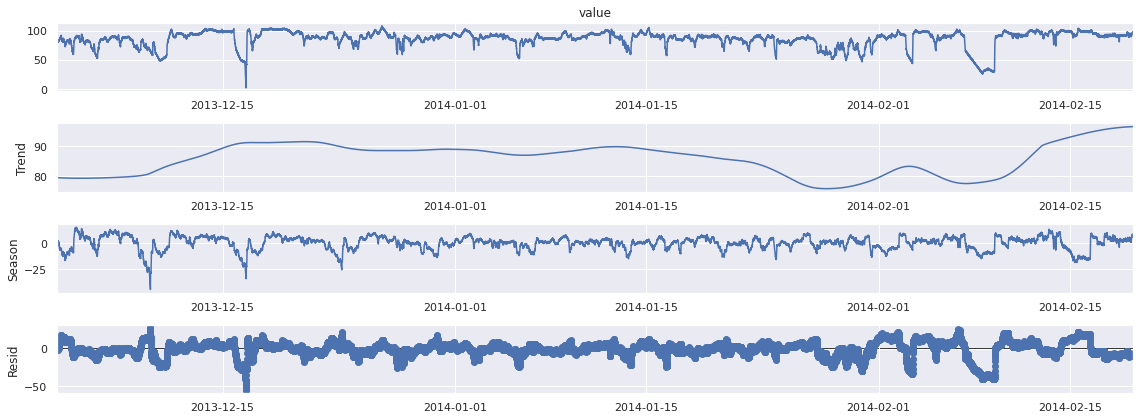

In [21]:
from statsmodels.tsa.seasonal import STL

res_weekly = STL(df['value'], period=2016).fit() #weekly seasonality
results_ = res_weekly.plot()

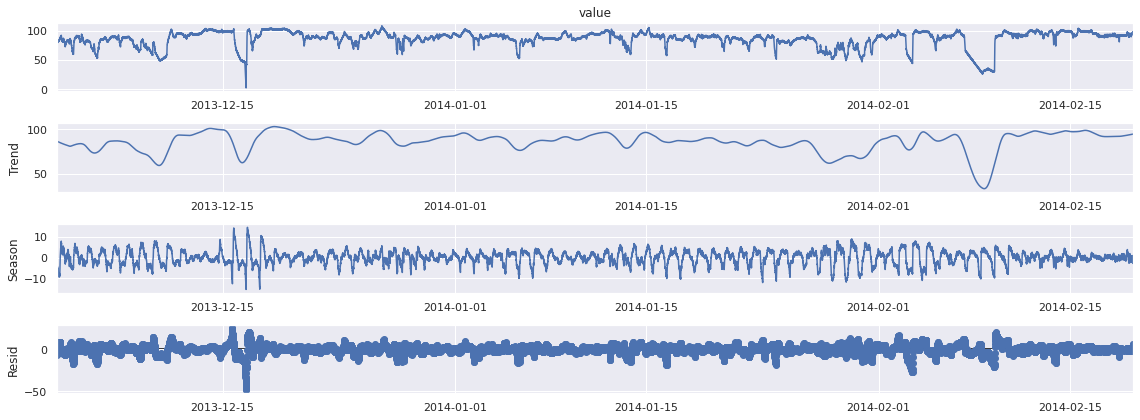

In [22]:
from statsmodels.tsa.seasonal import STL

res_daily = STL(df['value'], period=288).fit() #daily seasonality
results_ = res_daily.plot()

# 3. Feature Engineering

For time series, date-time features (timestamps), lag features (prior time steps) and window features (fixed window of prior time steps) can be created. 

The rolling window size is set based on *Amarbayasgalan, T.; Pham, V.H.; Theera-Umpon, N.; Ryu, K.H. Unsupervised Anomaly Detection Approach for Time-Series in Multi-Domains Using Deep Reconstruction Error. Symmetry 2020, 12, 1251*. The autors are applied their novel DL technique to several datasets, in which Numenta *machine_temperature_system_failure.csv* is among them.

In [23]:
WINDOW_SIZE = 30
df_train = df.copy()

In [24]:
df_train.insert(1, 'hour', df.index.hour)
df_train.insert(2, 'day_of_week', df.index.dayofweek)
df_train.insert(3, 'rw_first_deriv', df['value'].diff().abs().rolling(WINDOW_SIZE).mean())
df_train.insert(4, 'rw_second_deriv', df['value'].diff().diff().abs().rolling(WINDOW_SIZE).mean())
df_train.insert(5, 'rw_kurtosis', df['value'].rolling(WINDOW_SIZE).kurt())
df_train.insert(6, 'rw_skewness', df['value'].rolling(WINDOW_SIZE).skew())

In [25]:
df_train = df_train.drop(df.index[:WINDOW_SIZE + 1])

In [26]:
df_train.head()

,value,hour,day_of_week,rw_first_deriv,rw_second_deriv,rw_kurtosis,rw_skewness,is_anomaly
timestamp,,,,,,,,
2013-12-02 23:50:00,81.562356,23,0,0.900709,1.481137,2.406514,-1.100748,False
2013-12-02 23:55:00,81.435534,23,0,0.865327,1.474952,0.074102,-0.321201,False
2013-12-03 00:00:00,81.908156,0,1,0.813863,1.467324,-0.206266,-0.148496,False
2013-12-03 00:05:00,82.455751,0,1,0.792479,1.442243,-0.110131,-0.218886,False
2013-12-03 00:10:00,83.027583,0,1,0.790893,1.382766,-0.387020,0.056927,False


# 4. Modelling

## 4.1. Isolation Forest

First, PCA-applied statistical features will feed into the model together with date-time features, then only date-time features will feed into the model. 

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
meta_features_pca = pca.fit_transform(df_train[['rw_first_deriv', 'rw_second_deriv','rw_kurtosis', 'rw_skewness']])

In [28]:
df_train.insert(7, 'pca', meta_features_pca)

In [29]:
df_train.head()

,value,hour,day_of_week,rw_first_deriv,rw_second_deriv,rw_kurtosis,rw_skewness,pca,is_anomaly
timestamp,,,,,,,,,
2013-12-02 23:50:00,81.562356,23,0,0.900709,1.481137,2.406514,-1.100748,3.121941,False
2013-12-02 23:55:00,81.435534,23,0,0.865327,1.474952,0.074102,-0.321201,0.742978,False
2013-12-03 00:00:00,81.908156,0,1,0.813863,1.467324,-0.206266,-0.148496,0.451048,False
2013-12-03 00:05:00,82.455751,0,1,0.792479,1.442243,-0.110131,-0.218886,0.551315,False
2013-12-03 00:10:00,83.027583,0,1,0.790893,1.382766,-0.387020,0.056927,0.257022,False


In [30]:
columns_to_use = ['value', 'hour', 'day_of_week', 'pca']

In [31]:
from sklearn.ensemble import IsolationForest

model = IsolationForest()
clf = model.fit(df_train[columns_to_use])

df_train['scores'] = model.decision_function(df_train[columns_to_use])
df_train['anomaly'] = clf.predict(df_train[columns_to_use])

<AxesSubplot:xlabel='scores', ylabel='Count'>

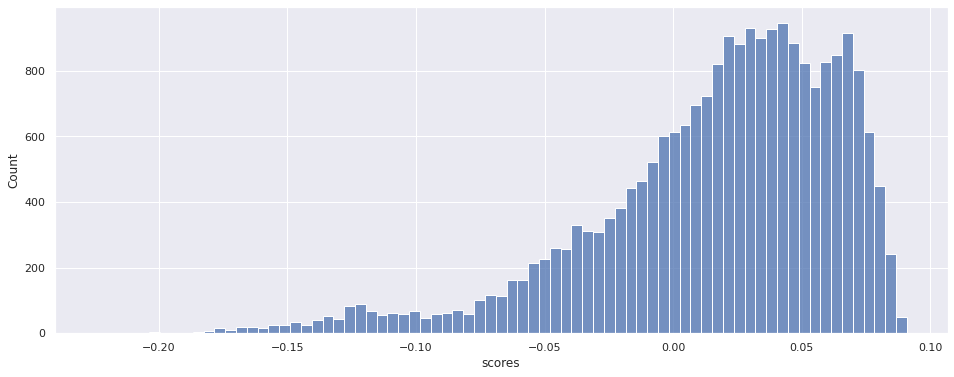

In [32]:
sns.histplot(df_train['scores'])

In [33]:
score_threshold = df_train.nsmallest(300, 'scores')['scores'].max()

<AxesSubplot:xlabel='timestamp', ylabel='value'>

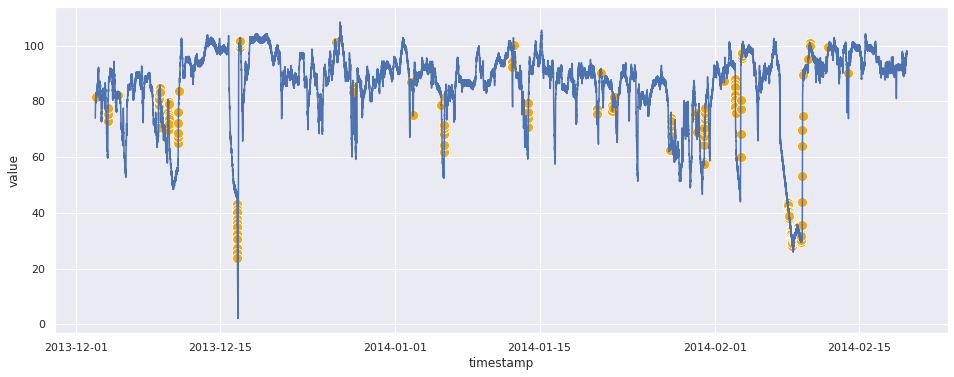

In [34]:
sns.lineplot(data=df, x='timestamp', y='value')
sns.scatterplot(data=df_train[df_train['scores'] < score_threshold],
                x='timestamp', y='value', color='orange', s=100)

Instead of using the contamination parameter of IF, the threshold for anomalies was set based on a proposed outlier fraction (300 / 22683 which makes approx. 0.013%). In Numenta machnine temperature dataset, there are only 4 anomalies in 22683 data points. The model with PCA applied features only located one exact time-date for anomalies, rather it proposed anomalies around two real anomaly points.

In [35]:
df_train[df_train['scores'] < score_threshold] ['is_anomaly'].sum()

0

In [36]:
# IF without PCA features
columns_to_use = ['value', 'hour', 'day_of_week']

model = IsolationForest()
clf = model.fit(df_train[columns_to_use])

df_train['scores'] = model.decision_function(df_train[columns_to_use])
df_train['anomaly'] = clf.predict(df_train[columns_to_use])

In [37]:
score_threshold = df_train.nsmallest(750, 'scores')['scores'].max()

<AxesSubplot:xlabel='timestamp', ylabel='value'>

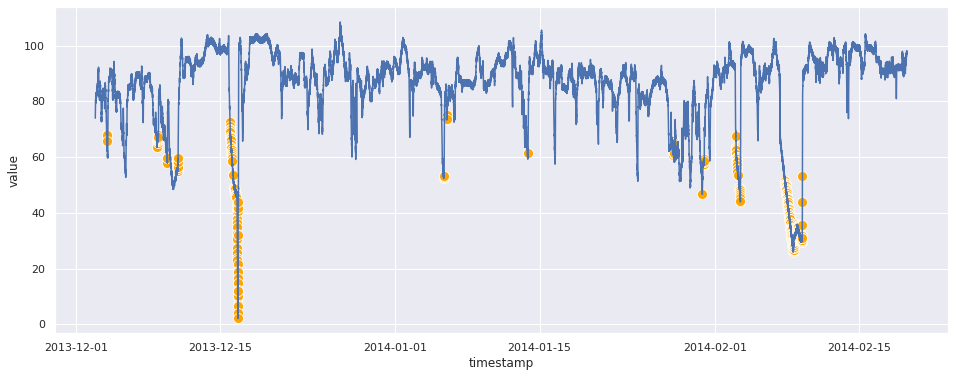

In [38]:
sns.lineplot(data=df, x='timestamp', y='value')
sns.scatterplot(data=df_train[df_train['scores'] < score_threshold],
                x='timestamp', y='value', color='orange', s=100)

In [39]:
df_train[df_train['scores'] < score_threshold] ['is_anomaly'].sum()

2

Isolation Forest without statistical features outperforms the IF with PCA. It located 2 anomalies with exact date time, and found several anomalies around the third anomaly. Besides, false positives are close to the anomaly points.

## 4.2. CNN Autoencoder

In this unsupervised approach, the idea is to learn a representation for windows of the time series values by training a convolutional autoencoder. The task for the autoencoder is to take the subsequence as input, and generate a reconstruction of it as output.

It is hoped that the anomalies will be harder to reconstruct (as, by defition, they consist of out of distribution sequences) and the corresponding reconstruction errors will be higher: We will classify an input subsequence as an anomaly if its reconstruction error is higher than a threshold.

In this and the following sections, CNN-based and RNN-based autoencoders will be trained, respectively. As DL systems has the potential to extract the features directly from the raw data, only the temperature values themselves will be used as input.

In [40]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [42]:
#normalize data

data = df['value'].copy()
data = (data - data.min()) / (data.max() - data.min())

In [43]:
WINDOW_SIZE = 256
N_SAMPLES = len(data) - WINDOW_SIZE

subsequences = np.zeros((N_SAMPLES, WINDOW_SIZE, 1))
for idx in range(N_SAMPLES):
    subsequences[idx] = data.iloc[idx : idx + WINDOW_SIZE].values.reshape((WINDOW_SIZE, 1))

subsequences = subsequences.transpose((0, 2, 1))
subsequences.shape

(22427, 1, 256)

### 4.2.1. Model Definition

In [44]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, 5),
            nn.ReLU(),
            nn.Conv1d(8, 32, 3),
            nn.ReLU(),
            nn.Conv1d(32, 64, 3),
            nn.ReLU(),
            nn.Conv1d(64, 32, 3),
            nn.ReLU(),
            nn.Conv1d(32, 8, 3),
            nn.ReLU(),
            nn.Conv1d(8, 1, 3),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 8, 3),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 64, 3),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 8, 3),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, 5),
            nn.Sigmoid() # will take [0, 1] normalized input, so output in that same range using sigmoid
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### 4.2.2. Model Training

In [45]:
def train(model, data_array, num_epochs=15, batch_size=256, learning_rate=1e-3):
    torch.manual_seed(42)
    
    criterion = nn.MSELoss() # mean square error for measuring "reconstruction error"
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    
    dataset = TensorDataset(torch.Tensor(data_array))
    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size, 
                                               shuffle=True)
    
    training_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for step, dat in enumerate(train_loader):
            subsequences = dat[0].to(device)
            reconstructions = model(subsequences)
            
            loss = criterion(reconstructions, subsequences)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss += loss.item() * subsequences.size(0)

        print('Epoch {:3d} Average Loss: {:.6f}'.format(epoch + 1, epoch_loss/len(dataset)))
        
        training_losses.append(epoch_loss/len(dataset))
        
    return np.array(training_losses)

In [46]:
model = Autoencoder().to(device)
training_losses = train(model, subsequences)

Epoch   1 Average Loss: 0.018324
Epoch   2 Average Loss: 0.003234
Epoch   3 Average Loss: 0.000655
Epoch   4 Average Loss: 0.000341
Epoch   5 Average Loss: 0.000236
Epoch   6 Average Loss: 0.000202
Epoch   7 Average Loss: 0.000161
Epoch   8 Average Loss: 0.000154
Epoch   9 Average Loss: 0.000132
Epoch  10 Average Loss: 0.000130
Epoch  11 Average Loss: 0.000127
Epoch  12 Average Loss: 0.000125
Epoch  13 Average Loss: 0.000129
Epoch  14 Average Loss: 0.000137
Epoch  15 Average Loss: 0.000100


### 4.2.3. Model Testing & Visualization

#### 4.2.3.1. Reconstruction Errors

In [47]:
def test(model, data_array, visualize=True, vis_n=10, batch_size=512):
    dataset = TensorDataset(torch.Tensor(data_array))
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    reconstructions_all = np.zeros_like(data_array)
    
    n_processed = 0
    for i, dat in enumerate(test_loader):
        subsequences = dat[0].to(device)
        reconstructions = model(subsequences)
        reconstructions = reconstructions.detach().to('cpu').numpy()
        reconstructions_all[n_processed:n_processed+len(subsequences)] = reconstructions
        n_processed += len(subsequences)

    diffs = data_array.squeeze() - reconstructions_all.squeeze()
    reconstruction_errors = (diffs * diffs).sum(axis=1)
    reconstruction_errors_stds = (diffs * diffs).std(axis=1)
        
    if visualize:
        fig, axes = plt.subplots(nrows=vis_n, ncols=2, sharex=True, figsize=(25,20))
        
        idxs = reconstruction_errors.argsort()
        best_rec_idxs, worst_rec_idxs = idxs[:vis_n], idxs[-vis_n:]
        
        axes[0,0].set_title('Top {} (Best) Reconstructions'.format(vis_n))
        for i, idx in enumerate(best_rec_idxs):
            axes[i][0].plot(data_array[idx].T)
            axes[i][0].plot(reconstructions_all[idx].T)
            
        axes[0,1].set_title('Bottom {} (Worst) Reconstructions'.format(vis_n))
        for i, idx in enumerate(worst_rec_idxs):
            axes[i][1].plot(data_array[idx].T)
            axes[i][1].plot(reconstructions_all[idx].T)
    
    return reconstructions_all, reconstruction_errors, reconstruction_errors_stds

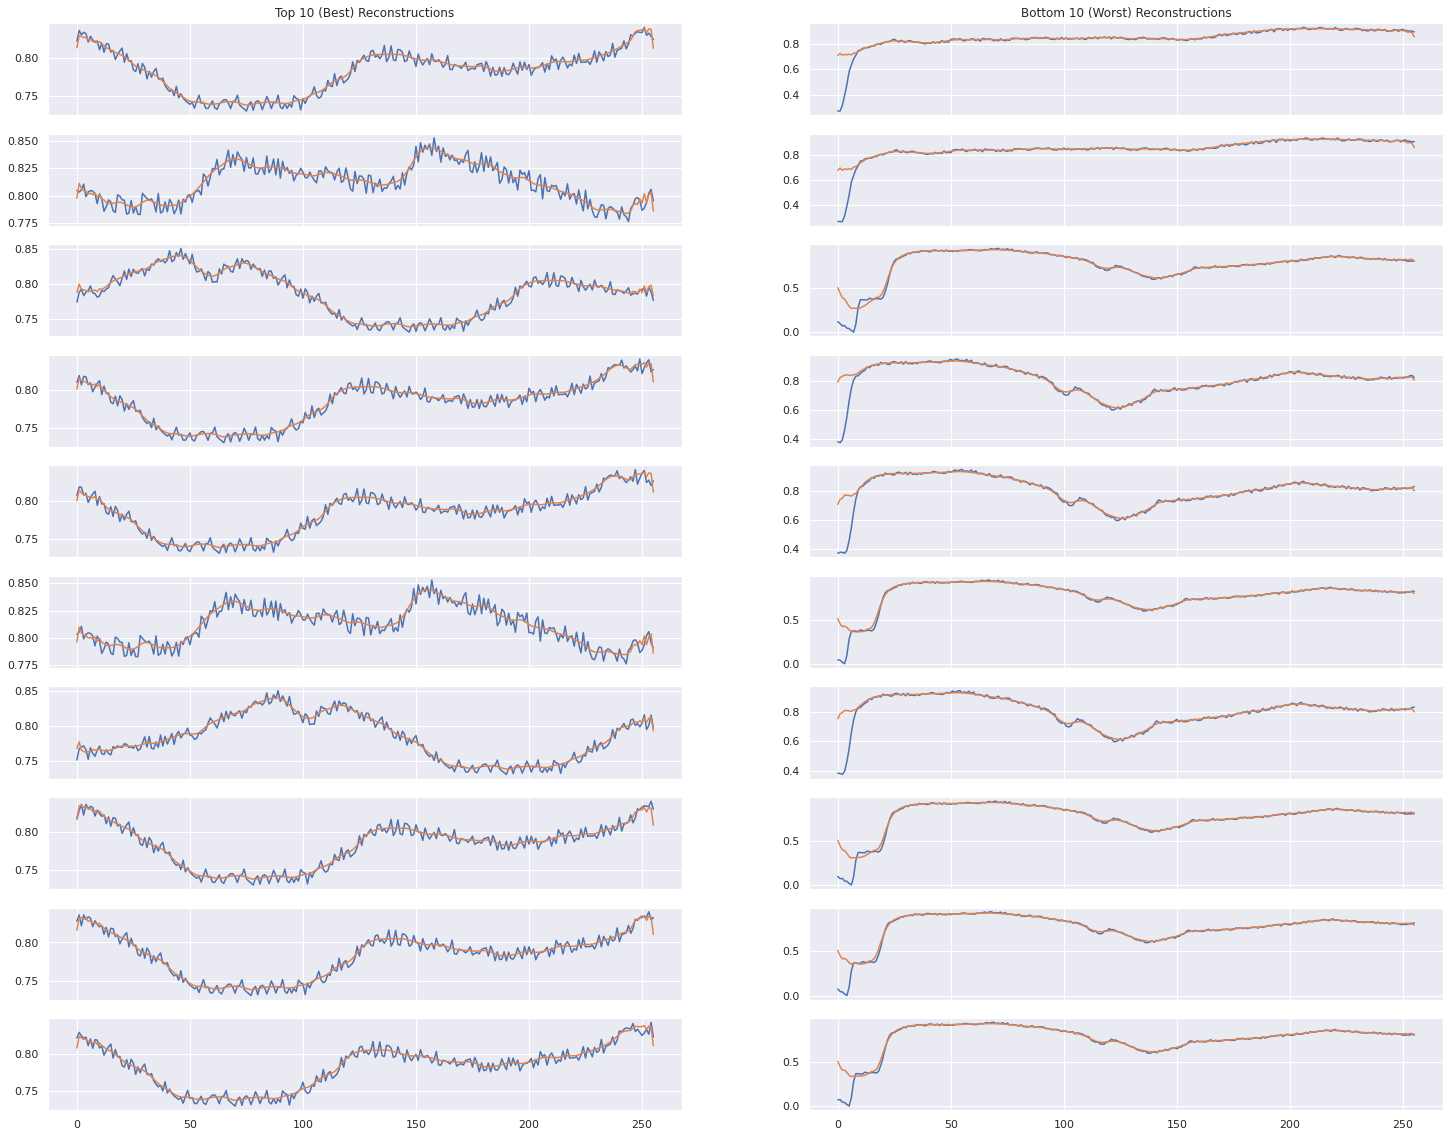

In [48]:
reconstructions, reconstruction_errors, reconstruction_errors_stds = test(model, subsequences)

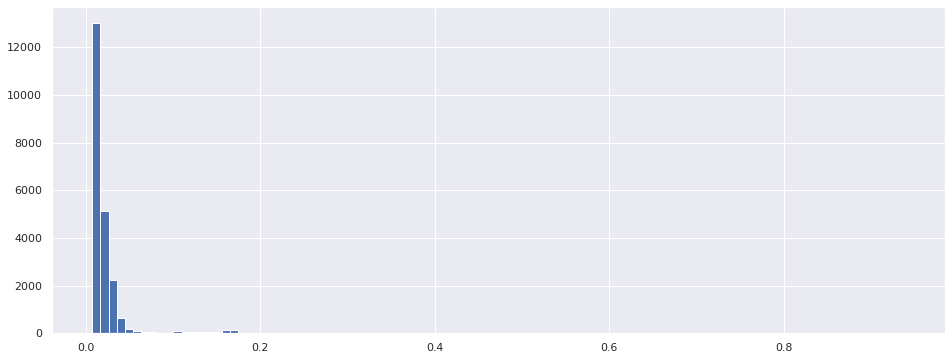

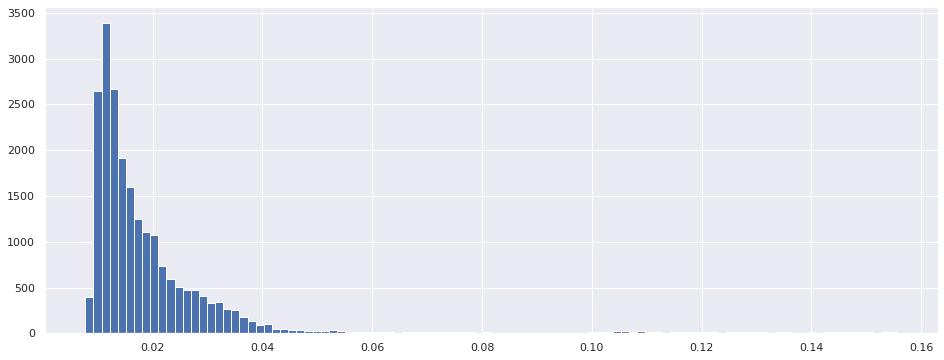

In [49]:
plt.hist(reconstruction_errors, bins=100);
plt.show()
plt.hist(sorted(reconstruction_errors)[:-500], bins=100);
plt.show()

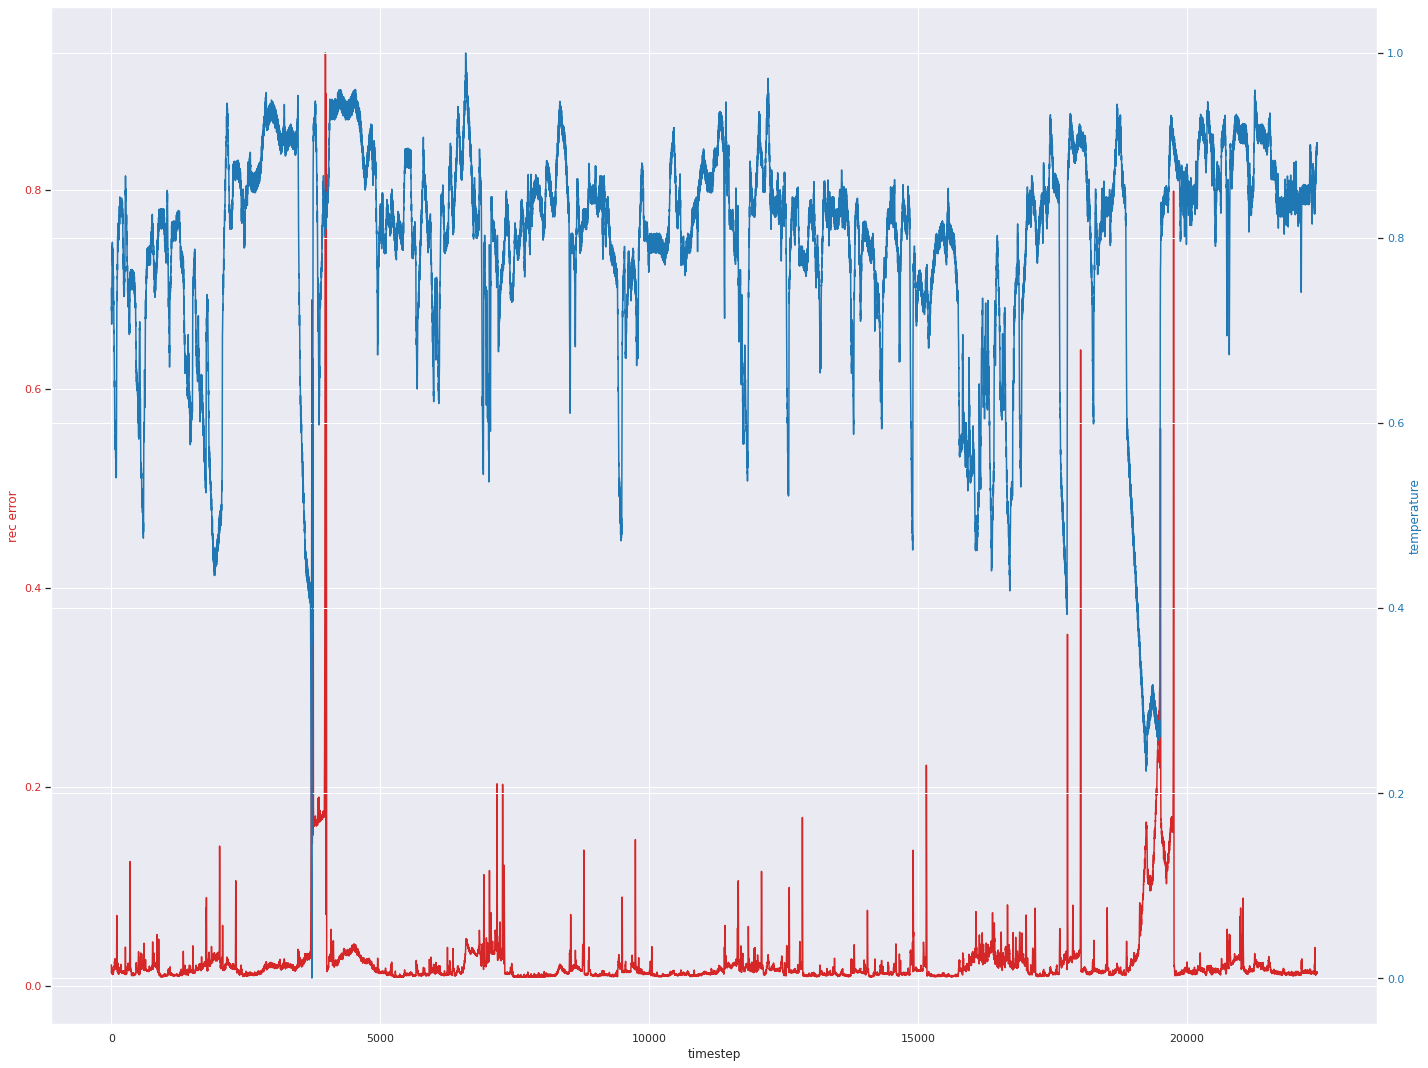

In [50]:
fig, ax1 = plt.subplots(figsize=(20, 15))

color = 'tab:red'
ax1.set_xlabel('timestep')
ax1.set_ylabel('rec error', color=color)
ax1.plot(reconstruction_errors, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('temperature', color=color)
ax2.plot(data.values[WINDOW_SIZE:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

As mentioned before, high reconstruction error is interpreted as anomalies. So, the model seems to correctly detect two anomalies located at the dips of the temperature as it gives very high error peaks for those points. There are also two false positives where the model gave similarly large reconstruction errors.

In conclusion, selecting a threshold of around 0.3 gives two true positives and two false positives.

#### 4.2.3.2. Embedding Visualization

In [51]:
def embed(model, data_array, flatten=True, batch_size=512):
    dataset = TensorDataset(torch.Tensor(data_array))
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    embeddings_all = list() 
    for i, dat in enumerate(test_loader):
        subsequences = dat[0].to(device)
        embeddings = model.encoder(subsequences)
        embeddings = embeddings.detach().to('cpu').numpy()
        
        if flatten:
            embeddings = embeddings.reshape(embeddings.shape[0], -1)
        
        embeddings_all.extend(embeddings)
        
    return np.array(embeddings_all)

In [52]:
embeddings = embed(model, subsequences)
embeddings.shape

(22427, 242)

In [53]:
from sklearn.manifold import TSNE
embeddings_tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(embeddings)
embeddings_tsne.shape

(22427, 2)

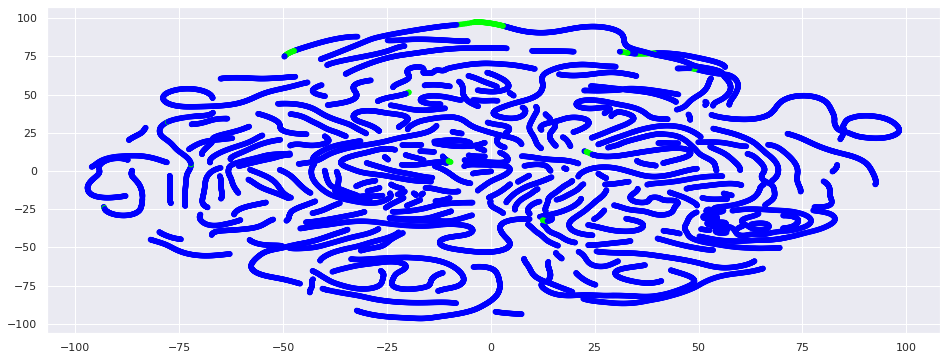

In [54]:
import matplotlib.cm as cm
plt.scatter(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], c=reconstruction_errors > 0.2, s=20, cmap=cm.brg);

Here $2$-dimensional projections of the embeddings (which are of dimension 242) are obtained using the TSNE algorithm. It can be seen that the model did not learn a good representation of the data as the anomalies do not get to be mapped to separate clusters.

It can be claimed that a higher performing model could be obtained using an architecture that would generate lower dimensional embeddings (*e.g.*, using pooling).

## 4.3. RNN Autoencoder

Here, we apply the exact same idea with a recurrent architecture, namely a GRU autoencoder.

In [55]:
WINDOW_SIZE = 32
N_SAMPLES = len(data) - WINDOW_SIZE

subsequences = np.zeros((N_SAMPLES, WINDOW_SIZE, 1))
for idx in range(N_SAMPLES):
    subsequences[idx] = data.iloc[idx : idx + WINDOW_SIZE].values.reshape((WINDOW_SIZE, 1))
subsequences.shape

(22651, 32, 1)

### 4.3.1. Model Definition

In [56]:
DATA_DIMENSION = 1
EMBEDDING_DIMENSION = 128

class EncoderRNN(nn.Module):
    def __init__(self, window_size, input_dimension=DATA_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION):
        super(EncoderRNN, self).__init__()
        
        self.window_size = window_size
        self.input_dimension = input_dimension
        self.embedding_dimension = embedding_dimension
        self.hidden_dimension = 2 * embedding_dimension
        
        self.RNN1 = nn.GRU(
                input_size=self.input_dimension,
                hidden_size=self.hidden_dimension,
                num_layers=1,
                batch_first=True
            )
        
        self.RNN2 = nn.GRU(
                input_size=self.hidden_dimension,
                hidden_size=self.embedding_dimension,
                num_layers=1,
                batch_first=True
            )
        
    def forward(self, x):
        x, _ = self.RNN1(x)
        x, hidden = self.RNN2(x)
        return hidden # .squeeze() #.reshape((self.input_dimension, self.embedding_dimension))
    
class DecoderRNN(nn.Module):
    def __init__(self, window_size, input_dimension=EMBEDDING_DIMENSION, output_dimension=DATA_DIMENSION):
        super(DecoderRNN, self).__init__()
        
        self.window_size = window_size
        self.input_dimension = input_dimension
        self.hidden_dimension = 2 * input_dimension
        self.output_dimension = output_dimension
        
        
        self.RNN1 = nn.GRU(
                input_size=self.input_dimension,
                hidden_size=self.input_dimension,
                num_layers=1,
                batch_first=True,
            )
        
        self.RNN2 = nn.GRU(
                input_size=self.input_dimension,
                hidden_size=self.hidden_dimension,
                num_layers=1,
                batch_first=True,
            )
        
        self.output = nn.Linear(self.hidden_dimension, self.output_dimension)
        
    def forward(self, x):
        x = x.repeat(self.window_size, 1, 1).transpose(0, 1)
        x, _ = self.RNN1(x)
        x, _ = self.RNN2(x)
        x = x.reshape((-1, self.window_size, self.hidden_dimension))
        x = self.output(x)
        return x
    
class AutoencoderRNN(nn.Module):
    def __init__(self, window_size, input_dimension=DATA_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION):
        super(AutoencoderRNN, self).__init__()
        self.encoder = EncoderRNN(window_size, input_dimension, embedding_dimension)
        self.decoder = DecoderRNN(window_size, embedding_dimension, input_dimension)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### 4.3.2. Model Training

In [57]:
model = AutoencoderRNN(WINDOW_SIZE).to(device)
losses = train(model, subsequences, num_epochs=10)

Epoch   1 Average Loss: 0.026414
Epoch   2 Average Loss: 0.000889
Epoch   3 Average Loss: 0.000886
Epoch   4 Average Loss: 0.000867
Epoch   5 Average Loss: 0.000823
Epoch   6 Average Loss: 0.000840
Epoch   7 Average Loss: 0.000750
Epoch   8 Average Loss: 0.000784
Epoch   9 Average Loss: 0.000754
Epoch  10 Average Loss: 0.000735


### 4.3.3. Model Testing & Visualization

In [58]:
def test_rnn(model, data_array, visualize=True, vis_n=20, batch_size=128):
    dataset = TensorDataset(torch.Tensor(data_array))
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    reconstructions_all = np.zeros_like(data_array)
    
    n_processed = 0
    for i, dat in enumerate(test_loader):
        subsequences = dat[0].to(device)
        reconstructions = model(subsequences)
        reconstructions = reconstructions.detach().to('cpu').numpy()
        reconstructions_all[n_processed:n_processed+len(subsequences)] = reconstructions
        n_processed += len(subsequences)

    diffs = data_array.squeeze() - reconstructions_all.squeeze()
    reconstruction_errors = (diffs * diffs).sum(axis=1)
    reconstruction_errors_stds = (diffs * diffs).std(axis=1)
        
    if visualize:
        fig, axes = plt.subplots(nrows=vis_n, ncols=2, sharex=True, figsize=(25,20))
        
        idxs = reconstruction_errors.argsort()
        best_rec_idxs, worst_rec_idxs = idxs[:vis_n], idxs[-vis_n:]
        
        axes[0,0].set_title('Top {} (Best) Reconstructions'.format(vis_n))
        for i, idx in enumerate(best_rec_idxs):
            axes[i][0].plot(data_array[idx])
            axes[i][0].plot(reconstructions_all[idx])
            
        axes[0,1].set_title('Bottom {} (Worst) Reconstructions'.format(vis_n))
        for i, idx in enumerate(worst_rec_idxs):
            axes[i][1].plot(data_array[idx])
            axes[i][1].plot(reconstructions_all[idx])
    
    return reconstructions_all, reconstruction_errors, reconstruction_errors_stds

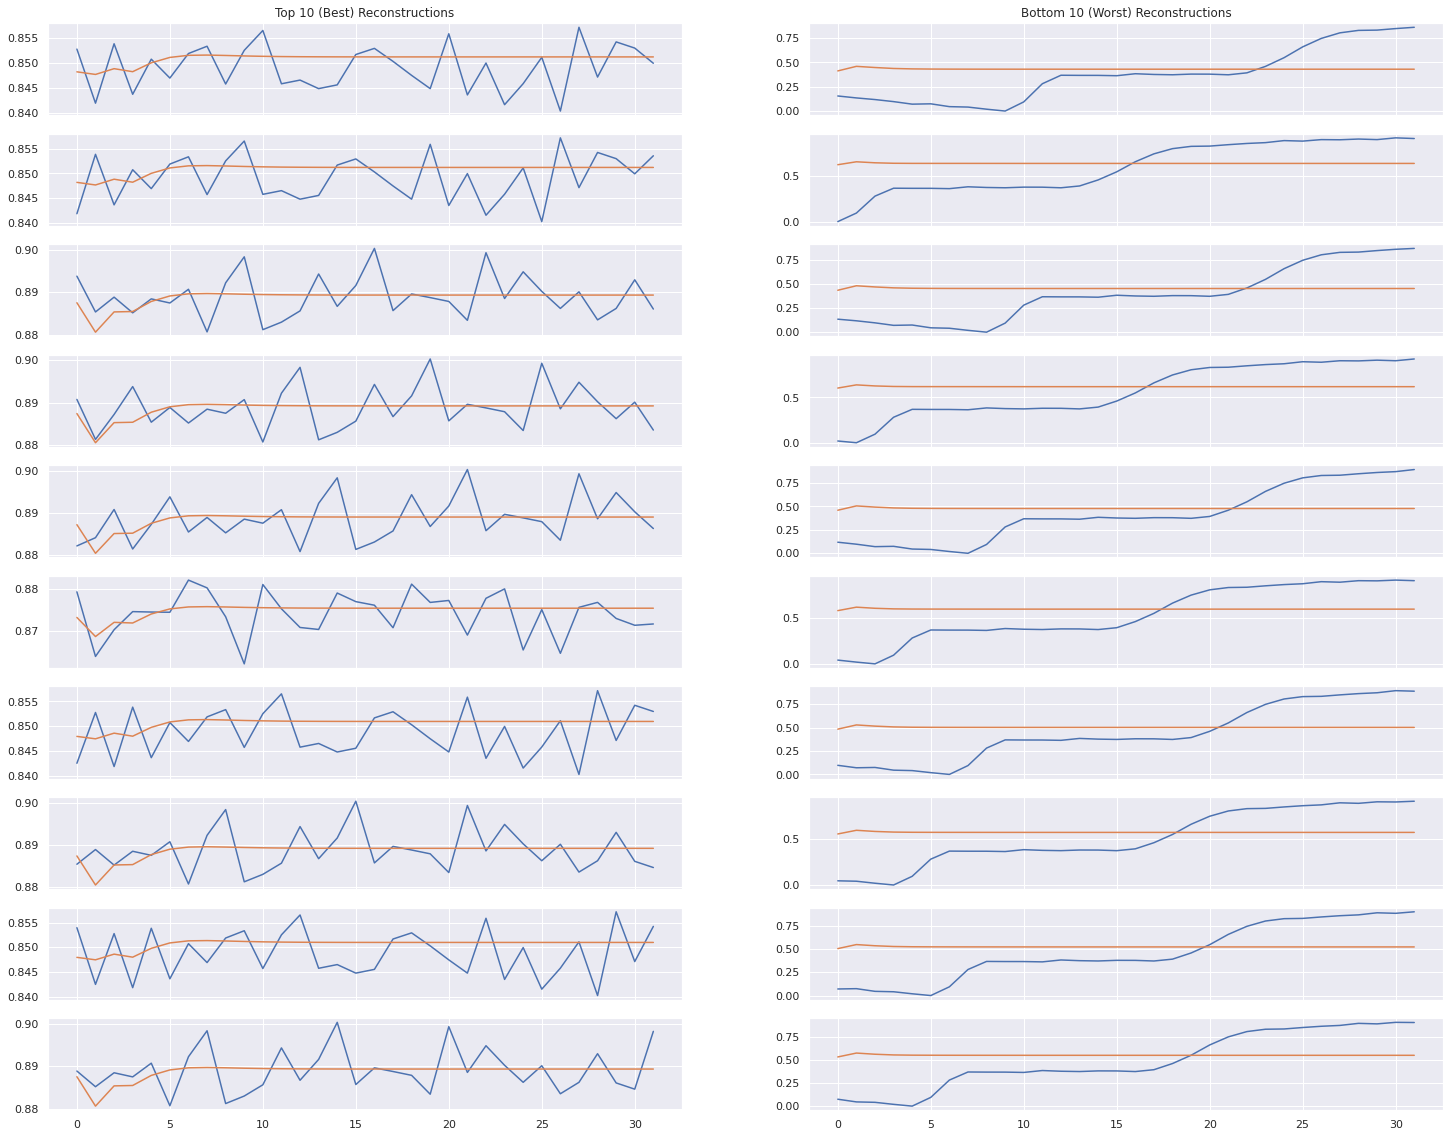

In [59]:
reconstructions, reconstruction_errors, reconstruction_errors_stds = test_rnn(model, subsequences, vis_n=10)

Even the best reconstructions do not seem to capture the input data, so, apparently, the model did not learn a nice representation.

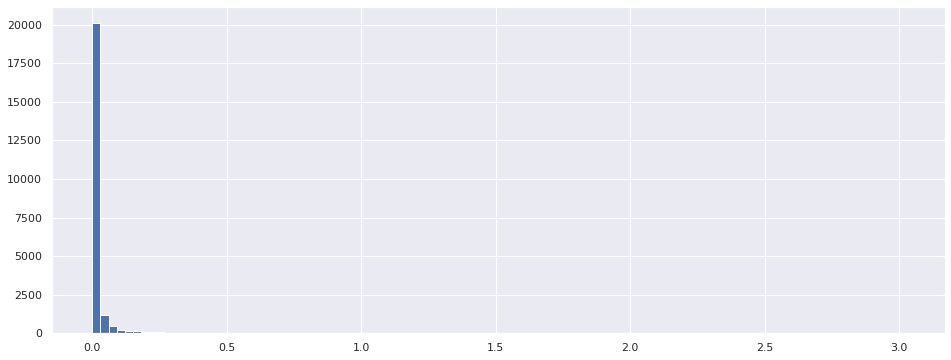

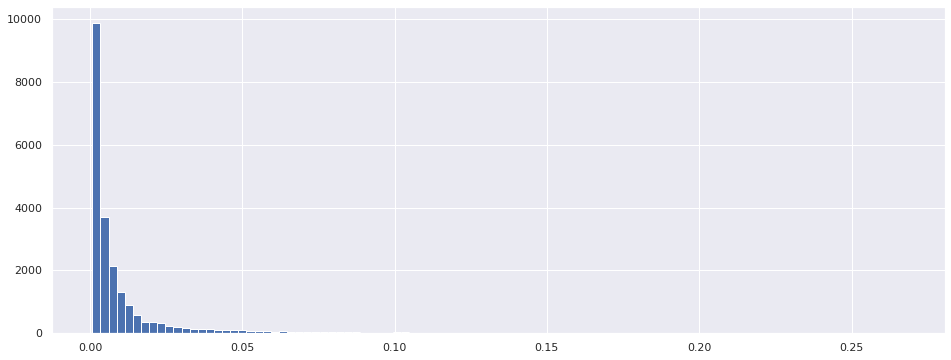

In [60]:
plt.hist(reconstruction_errors, bins=100);
plt.show()
plt.hist(sorted(reconstruction_errors)[:-200], bins=100);
plt.show()

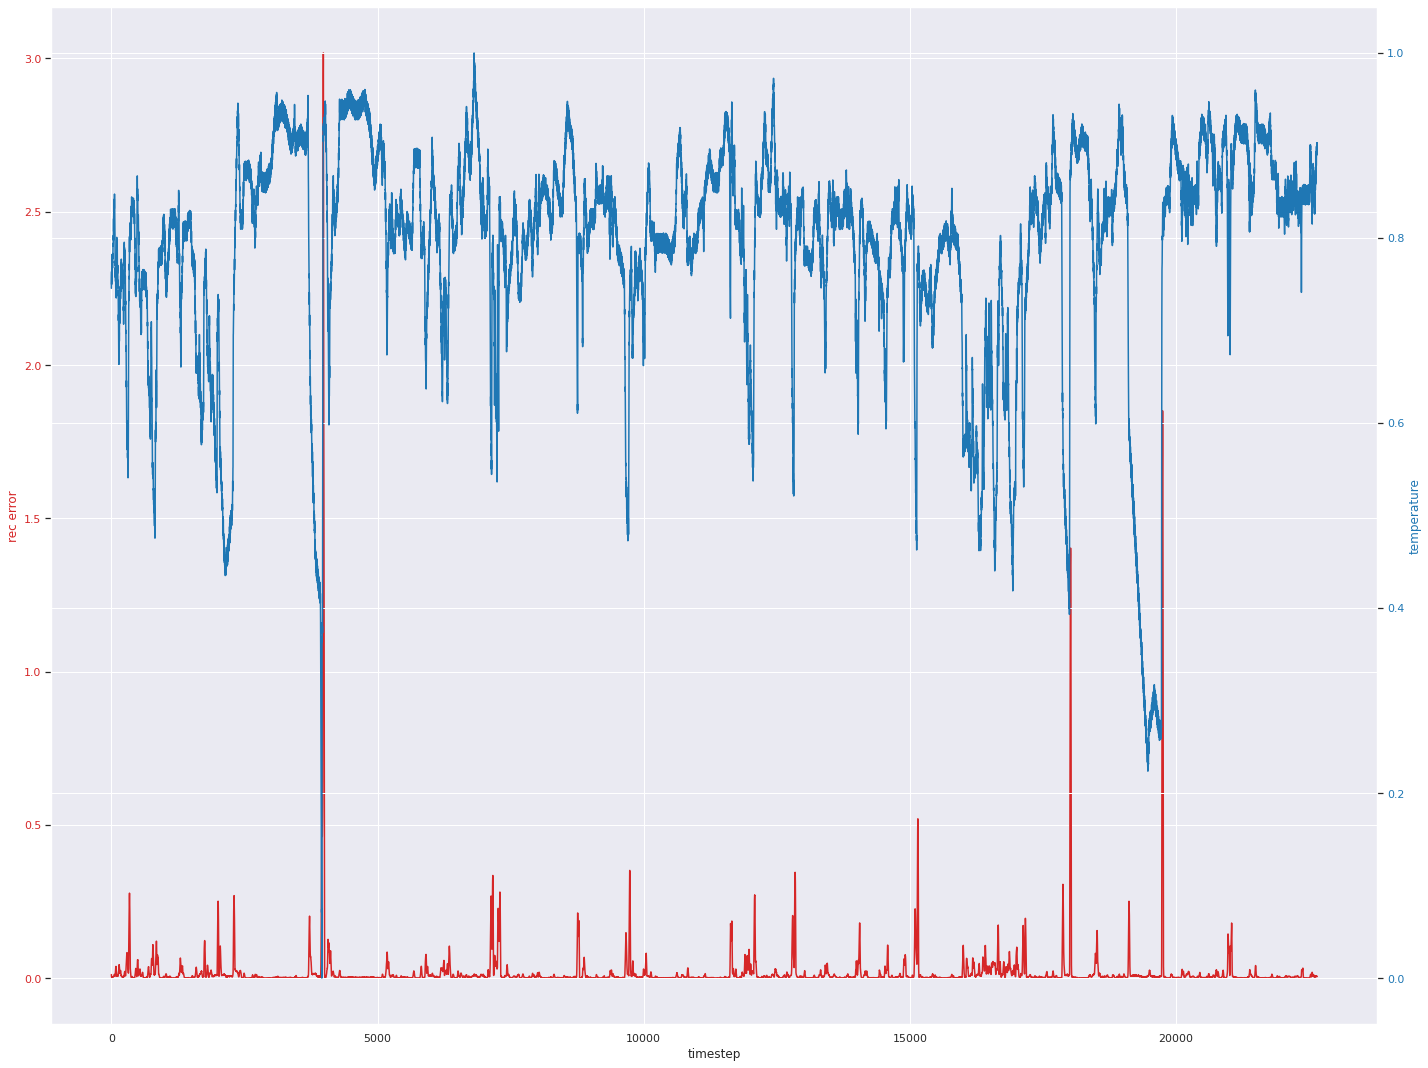

In [61]:
fig, ax1 = plt.subplots(figsize=(20, 15))

color = 'tab:red'
ax1.set_xlabel('timestep')
ax1.set_ylabel('rec error', color=color)
ax1.plot(reconstruction_errors, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('temperature', color=color)
ax2.plot(data.values[WINDOW_SIZE:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

As can be inferred from the low quality reconstructions, the model is not able to distinguish between "normal" points and anomaly points well: Even though the largest peaks are near the anomaly points, they are not located at their exact locations.

It is obvious that the model performs poorly, although it was expected that a recurrent architecture would better capture the characteristic of the data. Better hyperparameter search is needed. Specifically, an LSTM structure that is trained on a larger window size (larger than 32 used here) could better exploit the sequence context.